# Main

## Mount Google Drive, Link to folder & install requirements

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6756"
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

## Imports

In [ ]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# My modules
from models import Wgan, Autoencoder
from run_exp import train_autoencoder
from utils import to_device, train_val_test_split

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

torch.manual_seed(42)

## Arguments

In [ ]:
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_size: int = 9
  latent_dim: int = 100  # How to find this ? 

  # Optimization
  n_critic: int = 5
  clip_value: float = 0.01
  lr: float = 1e-3
  epochs: int = 10  # More eventually 

  # Experiment
  # exp_id: str = 'debug'
  # log: bool = True
  # log_dir: str = '/content/gdrive/MyDrive/IFT6756/logs'
  # seed: int = 42

  # Miscellaneous
  device: str = 'cuda'
  # num_workers: int = 2
  # progress_bar: bool = False
  # print_every: int = 10


@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 7  
  hidden: Tuple[int, ...] = (9, 8)

  # Optimization
  lr: float = 1e-3
  epochs: int = 100 

  # Miscellaneous
  device: str = 'cpu'


## Data

The features are

- NP: Number of household people
- HHT: Household or family type
- HINCP: Household income 
- HUPAC: Household presence and age of children 
- WIF: Workers in family during the last 12 months
- AGEP: Age of the person
- SEX: Gender of the person
- ESR: Employment status of the person 
- RAC1P: Recorded detailed race 


In [ ]:
# Load data 
"""
# Uncomment this block to create train, val, test sets from the data
dfs = []
for i in range(1, 5):
  path = f'/content/gdrive/MyDrive/IFT6756/data/PUMA-120{i}-2012to2016-5%_Treated.csv'
  dfs.append(pd.read_csv(path))
df = pd.concat(dfs, axis=0, ignore_index=True)
train, val, test = train_val_test_split(df)
"""

# Load data (numpy arrays)
train = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train.csv', index_col=0).values
val = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/val.csv', index_col=0).values
test = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test.csv', index_col=0).values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
val_tensor = torch.tensor(val, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

## Pretraining the decoder

### Initialization

In [ ]:
# Experiment's details
args = Arguments_ae(batch_size=16,
                    input_dim=9,
                    latent_dim=64,
                    hidden=(9,16,32),
                    lr=1e-3,
                    epochs=50,
                    device="cuda")

In [ ]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(val_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [ ]:
# Model
autoencoder = Autoencoder(args)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (input_layer): Linear(in_features=9, out_features=9, bias=True)
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=9, bias=True)
    )
    (output_layer): Linear(in_features=9, out_features=9, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


### Training

In [ ]:
# Training
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

### Visualization

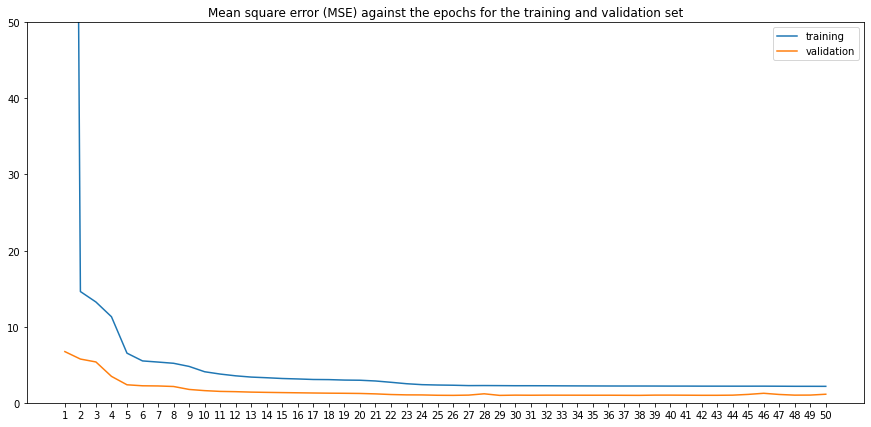

In [ ]:
# Plot validation and training losses
epochs = range(1, args.epochs+1)
plt.figure(figsize=(15, 7))
plt.title("Mean square error (MSE) against the epochs for the training and validation set")
plt.plot(epochs, autoencoder.logs["train loss"], label="training")
plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
plt.xticks(epochs)
plt.ylim((0, 50))
plt.legend(loc=1)
plt.show()

In [ ]:
# Examples of reconstructions on validation set
n = 10
idx = random.sample(range(len(val)), n)
for i in idx:
  example = val_tensor[i].to(args.device)
  print("\nTarget")
  print(example)
  print("Reconstruction")
  print(autoencoder.decoder(autoencoder.encoder(example)))
  print("Encoding")
  print(autoencoder.encoder(example))



Target
tensor([ 5.,  4., 23.,  1.,  1.,  1.,  4.,  4.,  1.], device='cuda:0')
Reconstruction
tensor([ 5.1273,  3.8648, 23.5963,  1.0086,  1.3221,  1.5113,  3.7430,  4.0251,
         1.3803], device='cuda:0', grad_fn=<ReluBackward0>)
Encoding
tensor([ 0.2294,  0.0037,  0.2568,  0.0012,  0.5359,  0.2220,  0.0376, -0.0636,
        -0.2778,  0.2262, -0.1464, -0.0933, -0.1110,  0.1254, -0.3028, -0.2330,
        -0.0459, -0.2613, -0.1261, -0.5804,  0.3111,  0.3841, -0.5469, -0.1613,
         0.2094, -0.2601,  0.1206,  0.0068,  0.4051,  0.4385,  0.0354,  0.2145,
        -0.0311, -0.0318,  0.0566, -0.1434, -0.0533, -0.1286, -0.2318,  0.1174,
        -0.2072, -0.0027, -0.4765,  0.2766,  0.1921, -0.2235, -0.0193, -0.2345,
        -0.1917, -0.0796, -0.0166,  0.1610,  0.1327,  0.4585,  0.2517,  0.3265,
         0.5068,  0.1877, -0.4647,  0.2208, -0.1448,  0.3851, -0.0444, -0.2131],
       device='cuda:0', grad_fn=<TanhBackward>)

Target
tensor([ 5.,  3., 61.,  1.,  1.,  1.,  3.,  4.,  1.], device

### Save decoder

In [14]:
torch.save(autoencoder.decoder, "/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")